In [10]:
import json
import math
from collections import defaultdict
from ultralytics import RTDETR
import matplotlib.pyplot as plt
from PIL import Image


# -----------------------------
# Config
# -----------------------------
WEIGHTS = "/nuvodata/User_data/shiva/code/Data_Hackathon/Training_for_hackathon/train4/weights/best.pt"
IMAGE   = "/nuvodata/User_data/shiva/code/Data_Hackathon/Images/istockphoto-185096732-612x612_jpg.rf.d4396c3372c4ac2d69607db0329ec926.jpg"

# If your training used this exact order, keep it as-is:
CLASS_NAMES = ["Clean","Dirty","Light_On","Light_Off","Soap","Soap_Dispenser","Water","Tap"]
IDX = {n:i for i,n in enumerate(CLASS_NAMES)}

CONF_MIN = 0.20     # ignore tiny detections
IMG_SIZE = 640
ODOUR_GAMMA = 1.4   # >1 penalizes any "Dirty" more strongly; set 1.0 for linear

# -----------------------------
# Helpers
# -----------------------------
def aggregate_class_probs(detections, conf_min=CONF_MIN):
    """
    detections: list of (class_id:int, confidence:float)
    Aggregation: p_present = 1 - Π(1 - conf_i) over detections for that class
    """
    by_cls = defaultdict(list)
    for cid, conf in detections:
        p = float(conf)
        if p >= conf_min:
            by_cls[int(cid)].append(max(0.0, min(1.0, p)))

    agg = {}
    for c, ps in by_cls.items():
        prod = 1.0
        for p in ps:
            prod *= (1.0 - p)
        agg[c] = 1.0 - prod
    return agg

def get(cls_probs, name):
    return float(cls_probs.get(IDX[name], 0.0))

def score_categories(cls_probs, eps=1e-6, odour_gamma=ODOUR_GAMMA):
    clean     = get(cls_probs, "Clean")
    dirty     = get(cls_probs, "Dirty")
    light_on  = get(cls_probs, "Light_On")
    light_off = get(cls_probs, "Light_Off")
    soap      = get(cls_probs, "Soap")
    disp      = get(cls_probs, "Soap_Dispenser")
    water     = get(cls_probs, "Water")
    tap       = get(cls_probs, "Tap")

    # Ratios
    cleanliness = 100.0 * ((clean + (1 - dirty)) / 2.0)

    lighting    = 100.0 * light_on 

    # Require both: geometric mean
    soap_disp   = 100.0 * math.sqrt(max(0.0, min(1.0, disp)) * max(0.0, min(1.0, soap)))

    # Weighted blend (tweak weights as you like)
    water_supply = 100.0 * max(0.0, min(1.0, 0.6 * tap + 0.4 * water))

    # Odour from Dirty only
    odour = 100.0 * (dirty ** odour_gamma)
    odour = max(0.0, min(100.0, odour))
    overall_score = ((cleanliness*4)+(lighting+soap_disp+water_supply+(100-odour)))/8

    return {
        "Overall Score":     round(overall_score, 1),
        "Cleanliness":     round(cleanliness, 1),
        "Lighting":        round(lighting, 1),
        "Soap Dispenser":  round(soap_disp, 1),
        "Water Supply":    round(water_supply, 1),
        "Odour Control":   round(odour, 1),
    }

# -----------------------------
# Inference
# -----------------------------
model = RTDETR(WEIGHTS)
# model.info()  # uncomment if you want to print model info

results = model.predict(IMAGE, imgsz=IMG_SIZE, conf=0.2, verbose=False)

# Collect detections (class_id, confidence)
dets = []
res = results[0]
if res.boxes is not None and len(res.boxes):
    cls = res.boxes.cls.int().cpu().numpy()
    conf = res.boxes.conf.cpu().numpy()
    for c, p in zip(cls, conf):
        dets.append((int(c), float(p)))

# Aggregate → Scores
cls_probs = aggregate_class_probs(dets, conf_min=CONF_MIN)
scores = score_categories(cls_probs, odour_gamma=ODOUR_GAMMA)

# Optional: include raw per-class presence probabilities in the JSON
raw_probs = {CLASS_NAMES[c]: round(float(v), 4) for c, v in cls_probs.items()}

output = {
    "image": IMAGE,
    "scores": scores,
    "class_presence_probabilities": raw_probs
}

print(json.dumps(output, indent=2))


{
  "image": "/nuvodata/User_data/shiva/code/Data_Hackathon/Images/istockphoto-185096732-612x612_jpg.rf.d4396c3372c4ac2d69607db0329ec926.jpg",
  "scores": {
    "Overall Score": 1.4,
    "Cleanliness": 1.7,
    "Lighting": 0.0,
    "Soap Dispenser": 0.0,
    "Water Supply": 0.0,
    "Odour Control": 95.3
  },
  "class_presence_probabilities": {
    "Dirty": 0.9661
  }
}


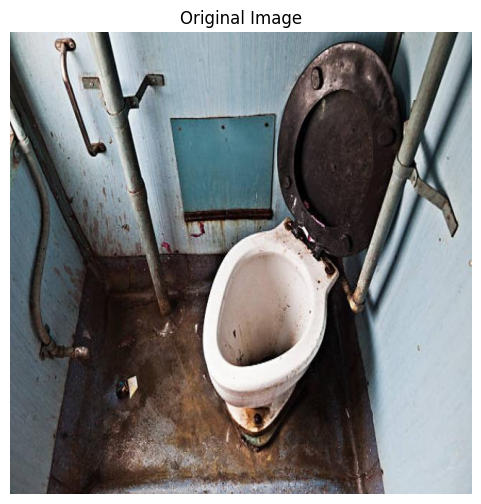

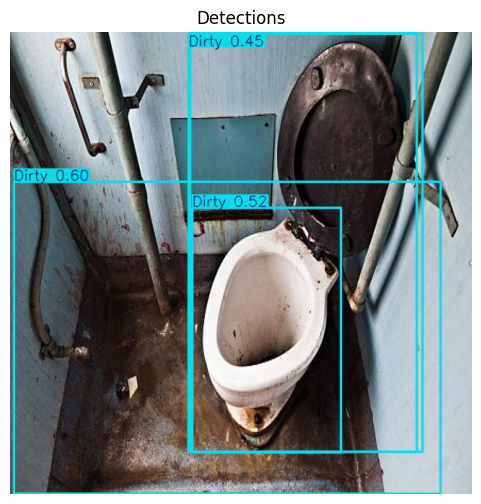

In [11]:
# -----------------------------
# Visualization
# -----------------------------

# Show original image
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(IMAGE))
plt.axis("off")
plt.title("Original Image")
plt.show()

# Show detected image with boxes
# Ultralytics results object has a .plot() method
detected_img = res.plot()  # returns a numpy array (BGR)
plt.figure(figsize=(6, 6))
plt.imshow(detected_img[..., ::-1])  # convert BGR→RGB
plt.axis("off")
plt.title("Detections")
plt.show()
